# Dataset Generation

In [2]:
import pandas as pd
from pathlib import Path
import json
import warnings
from generator.module import Generator
from generator.normalizer import Normalizer
from sklearn.model_selection import train_test_split
from generator.tools import filter_aliases
from tqdm import tqdm
import time

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# load config values
config_file = Path('config') / 'command_generator_config.json'
with open(config_file, 'r', encoding='utf-8') as fp:
    config = json.load(fp)

data_dir = Path(config['data_dir'])
output_dir = Path(config['output_dir'])
templates_filename = config['templates_filename']
entities_filename = config['entities_filename']
languages = config['languages']
id_size = config["id_size"]
extra_num_size = config['extra_num_size']
random_seed = config['random_seed']
test_ratio = config['split']['test_ratio']
valid_ratio = config['split']['valid_ratio']
train_ratio = config['split']['train_ratio']

# read dataframe
templates = pd.read_json(data_dir / templates_filename)[['id'] + languages]
entities = pd.read_json(data_dir / entities_filename)

# make train and test for templates
time_start = time.time()
gen = Generator(templates=templates, entities=entities)
df_temp = pd.DataFrame(columns=["id", "language", "text"])
for tem_id in tqdm(templates.id):
    for lan in languages:
        for text in gen.get_templates(tem_id, lan):
            df_temp = df_temp.append({
                "id": tem_id,
                "language": lan,
                "text": text
            }, ignore_index=True)
df_temp = drop_small_class(df_temp.drop_duplicates(), ['id', 'language'])
df_temp_train, df_temp_test_valid = train_test_split(df_temp,
                                                     train_size=train_ratio,
                                                     stratify=df_temp[['id', 'language']],
                                                     random_state=random_seed)


100%|██████████| 39/39 [00:10<00:00,  3.70it/s]


In [26]:
df_temp_train['language'].value_counts()

de    1181
en     992
fr     875
it     750
Name: language, dtype: int64

In [27]:
df_temp_test_valid['language'].value_counts()

de    297
en    247
fr    220
it    186
Name: language, dtype: int64

In [32]:
df_temp_test_valid = drop_small_class(df_temp_test_valid, ['language'])
df_temp_valid, df_temp_test = train_test_split(df_temp_test_valid,
                                               test_size=test_ratio / (valid_ratio + test_ratio),
                                               stratify=df_temp_test_valid[[ 'language']],
                                               random_state=random_seed)

In [35]:
# entities = entities[entities.language.isin(languages)]
# df_entities = pd.DataFrame(columns=["value", "type", "language"])
# for _, selected_entity in tqdm(entities.iterrows()):
#     aliases = selected_entity['aliases']
#     value = [str(selected_entity['value'])]
#     normalized_value = [selected_entity['normalizedValue']]
#     lang = selected_entity['language']
#     filtered_values = filter_aliases(aliases + value + normalized_value, lang)
#     for v in filtered_values:
#         df_entities = df_entities.append({
#             "value": v,
#             "language": lang,
#             "type": selected_entity.type
#         }, ignore_index=True)

df_entities = drop_small_class(df_entities, ['type', 'language'])
df_entities_train, df_entities_test_valid = train_test_split(df_entities,
                                                             train_size=train_ratio,
                                                             stratify=df_entities[['type', 'language']],
                                                             random_state=random_seed)


In [40]:
df_entities_test['language'].value_counts()

de    1167
en     885
fr     786
it     691
Name: language, dtype: int64

In [38]:
df_entities_test_valid = drop_small_class(df_entities_test_valid, ['language'])
df_entities_valid, df_entities_test = train_test_split(df_entities_test_valid,
                                                       test_size=test_ratio / (valid_ratio + test_ratio),
                                                       stratify=df_entities_test_valid[[ 'language']],
                                                       random_state=random_seed)

In [13]:
def drop_small_class(df, columns, thresh=2):
    df_group = df.groupby(columns).count()
    df_group = df_group[df_group.values < thresh]
    condition = [True] * len(df)
    for targets_ind in df_group.index:
        for match in zip(columns, targets_ind):
            condition = condition & (df[match[0]] != match[1])
    return df[condition]

In [45]:
# load config values
config_file = Path('config') / 'command_generator_config.json'
with open(config_file, 'r', encoding='utf-8') as fp:
    config = json.load(fp)

data_dir = Path("data/nmt_data", )
output_dir = Path(config['output_dir'])
threshold = config['permute_thresh']
languages = config['languages']


def read_train_valid_test(path, prefix, appendix, lans):
    train = pd.read_csv(path / (prefix + '_train' + appendix))
    valid = pd.read_csv(path / (prefix + '_valid' + appendix))
    test = pd.read_csv(path / (prefix + '_test' + appendix))

    train = train[train['language'].isin(lans)]
    valid = valid[valid['language'].isin(lans)]
    test = test[test['language'].isin(lans)]
    return train, valid, test

df_temp_train, df_temp_valid, df_temp_test = read_train_valid_test(output_dir, 'templates', '.csv', languages)
df_entities_train, df_entities_valid, df_entities_test = read_train_valid_test(output_dir, 'entities', '.csv', languages)


In [46]:
df_entities_valid['language'].value_counts()

de    6305
fr    4639
en    3985
it    3291
Name: language, dtype: int64

In [26]:
time_start = time.time()
gen = Generator(templates=templates, entities=entities)
df_temp = pd.DataFrame(columns=["id", "language", "text"])
for tem_id in templates.id:
    for lan in languages:
        for text in gen.get_templates(tem_id, lan):
            df_temp = df_temp.append({
                "id": tem_id,
                "language": lan,
                "text": text
            }, ignore_index=True)

In [34]:
j = df_temp.groupby(['id', 'language']).count()#
j[j.values <10]

text
id                               language      
Tv.NavigationDown.Init.Utterance en           9
Tv.NavigationOK.Init.Utterance   en           7
                                 fr           3

In [6]:
time_start = time.time()
entities = entities[entities.language.isin(languages)]
df_entities = pd.DataFrame(columns=["value", "type", "language"])
for _, selected_entity in tqdm(entities.iterrows()):
    aliases = selected_entity['aliases']
    value = [str(selected_entity['value'])]
    normalized_value = [selected_entity['normalizedValue']]
    lang = selected_entity['language']
    filtered_values = filter_aliases(aliases + value + normalized_value, lang)
    for v in filtered_values:
        df_entities = df_entities.append({
            "value": v,
            "language": lang,
            "type": selected_entity.type
        }, ignore_index=True)

36440it [04:00, 151.65it/s]


KeyboardInterrupt: 

In [7]:
df_entities

value        type language
0                   12 singles volume 1   AlbumName       en
1                                1 gott   AlbumName       en
2                     20 th century boy   AlbumName       en
3                   11 ta stock sound 2   AlbumName       en
4      20 jahre dj ötzi party ohne ende   AlbumName       de
...                                 ...         ...      ...
48692                     sciencesuisse  SeriesName       fr
48693                          The Fall  SeriesName       fr
48694                           Wissper  SeriesName       it
48695                       Strike Back  SeriesName       fr
48696             Créatures de légendes  SeriesName       fr

[48697 rows x 3 columns]

In [70]:
def drop_small_class(df, columns, thresh=4):
    df_group = df.groupby(columns).count()
    df_group = df_group[df_group.values < thresh]
    condition = True
    for targets_ind in df_group.index:
        for match in zip(columns, targets_ind):
            condition = condition & (df[match[0]] != match[1])
    return df[condition]

In [66]:
df_temp.groupby(['id', 'language']).count()

text
id                                   language      
Bluewin.NewsSummary.Init.Utterance   de          38
                                     en          40
                                     fr          38
                                     it          36
Localsearch.RainInfo.Init.Utterance  de          48
...                                             ...
Tv.WatchFromBeginning.Init.Utterance it          17
Tv.WatchNextEpisode.Init.Utterance   de          20
                                     en          13
                                     fr          14
                                     it          15

[156 rows x 1 columns]

In [82]:
df_temp

id language  \
0        MyCloud.OpenArea.Init.Utterance       en   
1        MyCloud.OpenArea.Init.Utterance       en   
2        MyCloud.OpenArea.Init.Utterance       en   
3        MyCloud.OpenArea.Init.Utterance       en   
4        MyCloud.OpenArea.Init.Utterance       en   
...                                  ...      ...   
4788  Tv.WatchNextEpisode.Init.Utterance       it   
4789  Tv.WatchNextEpisode.Init.Utterance       it   
4790  Tv.WatchNextEpisode.Init.Utterance       it   
4791  Tv.WatchNextEpisode.Init.Utterance       it   
4792  Tv.WatchNextEpisode.Init.Utterance       it   

                                          text  
0                show {MyCloudArea} on myCloud  
1                     {MyCloudArea} in myCloud  
2                play {MyCloudArea} on myCloud  
3                play {MyCloudArea} on myCloud  
4               go to {MyCloudArea} on myCloud  
...                                        ...  
4788             vorrei vedere la puntata dopo  
4789            riproduci il prossimo episodio  
4790  per favore riproduci la prossima puntata  
4791              riproduci puntata successiva  
4792               fai partire l'episodio dopo  

[4793 rows x 3 columns]

In [55]:
k = df_temp.groupby(['id', 'language']).count()#.value_counts()
i = k[k['value'] < 10].index

In [100]:
df = df_temp
columns = ['id', 'language']
df_group = df.groupby(columns).count()
df_group = df_group[df_group.values < 5]
condition = [True] * len(df)
for targets_ind in df_group.index:
    for match in zip(columns, targets_ind):
        condition = condition & (df[match[0]] != match[1])

In [101]:
df[condition]

id language  \
0        MyCloud.OpenArea.Init.Utterance       en   
1        MyCloud.OpenArea.Init.Utterance       en   
2        MyCloud.OpenArea.Init.Utterance       en   
3        MyCloud.OpenArea.Init.Utterance       en   
4        MyCloud.OpenArea.Init.Utterance       en   
...                                  ...      ...   
4788  Tv.WatchNextEpisode.Init.Utterance       it   
4789  Tv.WatchNextEpisode.Init.Utterance       it   
4790  Tv.WatchNextEpisode.Init.Utterance       it   
4791  Tv.WatchNextEpisode.Init.Utterance       it   
4792  Tv.WatchNextEpisode.Init.Utterance       it   

                                          text  
0                show {MyCloudArea} on myCloud  
1                     {MyCloudArea} in myCloud  
2                play {MyCloudArea} on myCloud  
3                play {MyCloudArea} on myCloud  
4               go to {MyCloudArea} on myCloud  
...                                        ...  
4788             vorrei vedere la puntata dopo  
4789            riproduci il prossimo episodio  
4790  per favore riproduci la prossima puntata  
4791              riproduci puntata successiva  
4792               fai partire l'episodio dopo  

[3646 rows x 3 columns]

In [95]:
len(df)

4793

In [102]:
def drop_small_class(df, columns, thresh=4):
    df_group = df.groupby(columns).count()
    df_group = df_group[df_group.values < thresh]
    condition = [True] * len(df)
    for targets_ind in df_group.index:
        for match in zip(columns, targets_ind):
            condition = condition & (df[match[0]] != match[1])
    return df[condition]


In [108]:
drop_small_class(df_temp.drop_duplicates(), ['id', 'language'], thresh=5).groupby(['id', 'language']).count()

text
id                                   language      
Bluewin.NewsSummary.Init.Utterance   de          38
                                     en          40
                                     it          36
Localsearch.RainInfo.Init.Utterance  de          48
                                     en          51
...                                             ...
Tv.WatchFromBeginning.Init.Utterance en          18
                                     it          17
Tv.WatchNextEpisode.Init.Utterance   de          20
                                     en          13
                                     it          15

[114 rows x 1 columns]

In [60]:
condition = True
for c in i:
    for e in zip(['type', 'language'],  c):
        condition = condition & (df_entities[e[0]] != e[1])
condition

0        False
1        False
2        False
3        False
4         True
         ...  
48692    False
48693    False
48694    False
48695    False
48696    False
Length: 48697, dtype: bool

In [61]:
df_entities[condition].groupby(['type', 'language']).count()

value
type                 language       
AlbumName            de          105
AppName              de          384
AreaName             de          318
BroadcastName        de         1746
CallingNumberType    de           33
FirstName            de          952
LastName             de          998
LocalsearchLocation  de         3609
MyCloudArea          de           53
NickName             de           20
RadioChannelName     de          800
SeriesName           de         5911
SportCompetitionName de           22
SportSportsName      de           10
TrackName            de          209
TvChannelName        de         1218

In [ ]:
df_entities[df_entities['type', 'language']]

In [170]:
df_temp_train, df_temp_test_valid = train_test_split(df_temp,
                                                     train_size=train_ratio,
                                                     stratify=df_temp[['id', 'language']],
                                                     random_state=random_seed)


In [110]:
import pandas as pd
from pathlib import Path
import json
import warnings
from generator.module import Generator
from generator.normalizer import Normalizer
from sklearn.model_selection import train_test_split
from generator.tools import filter_aliases
from tqdm import tqdm
import time

warnings.filterwarnings('ignore')


def drop_small_class(df, columns, thresh=4):
    df_group = df.groupby(columns).count()
    df_group = df_group[df_group.values < thresh]
    condition = [True] * len(df)
    for targets_ind in df_group.index:
        for match in zip(columns, targets_ind):
            condition = condition & (df[match[0]] != match[1])
    return df[condition]


# load config values
config_file = Path('config') / 'command_generator_config.json'
with open(config_file, 'r', encoding='utf-8') as fp:
    config = json.load(fp)

data_dir = Path(config['data_dir'])
output_dir = Path(config['output_dir'])
templates_filename = config['templates_filename']
entities_filename = config['entities_filename']
languages = config['languages']
id_size = config["id_size"]
extra_num_size = config['extra_num_size']
random_seed = config['random_seed']
test_ratio = config['split']['test_ratio']
valid_ratio = config['split']['valid_ratio']
train_ratio = config['split']['train_ratio']

# read dataframe
templates = pd.read_json(data_dir / templates_filename)[['id'] + languages]
entities = pd.read_json(data_dir / entities_filename)

# make train and test for templates
time_start = time.time()
gen = Generator(templates=templates, entities=entities)
df_temp = pd.DataFrame(columns=["id", "language", "text"])
for tem_id in tqdm(templates.id):
    for lan in languages:
        for text in gen.get_templates(tem_id, lan):
            df_temp = df_temp.append({
                "id": tem_id,
                "language": lan,
                "text": text
            }, ignore_index=True)
df_temp = drop_small_class(df_temp.drop_duplicates(), ['id', 'language'])
df_temp_train, df_temp_test_valid = train_test_split(df_temp,
                                                     train_size=train_ratio,
                                                     stratify=df_temp[['id', 'language']],
                                                     random_state=random_seed)
# df_temp_test_valid = drop_small_class(df_temp_test_valid, ['id', 'language'])
# df_temp_valid, df_temp_test = train_test_split(df_temp_test_valid,
#                                                test_size=test_ratio / (valid_ratio + test_ratio),
#                                                stratify=df_temp_test_valid[['id', 'language']],
#                                                random_state=random_seed)
# df_temp_train.to_csv(output_dir / "templates_train.csv", index=False)
# df_temp_valid.to_csv(output_dir / "templates_valid.csv", index=False)
# df_temp_test.to_csv(output_dir / "templates_test.csv", index=False)
# time_end = time.time()
# print("Templates split done:", time_end - time_start, 's')


100%|██████████| 39/39 [00:11<00:00,  3.40it/s]


In [112]:
df_temp_train

id language  \
4223  Router.SwitchOffGuestWiFi.Init.Utterance       de   
531       Tv.RadioChannelChange.Init.Utterance       de   
2480   Router.SwitchOnGuestWiFi.Init.Utterance       en   
2021              Tv.OpenUiArea.Init.Utterance       it   
1444         Tv.TvChannelChange.Init.Utterance       de   
...                                        ...      ...   
3786       Localsearch.RainInfo.Init.Utterance       en   
4044    Localsearch.WeatherInfo.Init.Utterance       de   
4591         Tv.NavigationRight.Init.Utterance       it   
3075       SmartHome.StartScene.Init.Utterance       de   
3974    Localsearch.WeatherInfo.Init.Utterance       en   

                                                   text  
4223                              Gäste Wlan ausstellen  
531              schalt um auf Radio {RadioChannelName}  
2480                     please turn on the guest Wi-Fi  
2021                           voglio aprire {AreaName}  
1444       auf TV Sender {TvChannelPosition} umschalten  
...                                                 ...  
3786                                      is there rain  
4044  gibt es {LocalsearchTimeStampStartDay} hässlic...  
4591                                             destra  
3075   bitte schalte die Szene {SmartHomeSceneName} ein  
3974                              weather update please  

[2898 rows x 3 columns]

In [111]:
df_temp_test_valid

id language  \
3363     SmartHome.SwitchOffDevice.Init.Utterance       it   
713   Router.ShowGuestWiFiPassword.Init.Utterance       de   
4615               Tv.NavigationUp.Init.Utterance       de   
478          Tv.RadioChannelChange.Init.Utterance       en   
4555             Tv.NavigationLeft.Init.Utterance       it   
...                                           ...      ...   
4521             Tv.NavigationLeft.Init.Utterance       de   
2681              Tv.TrickModePlay.Init.Utterance       en   
1037      SmartHome.SwitchOnDevice.Init.Utterance       en   
2340       Router.ShowWiFiPassword.Init.Utterance       en   
1843                   Tv.VolumeUp.Init.Utterance       de   

                                                   text  
3363                spegni la {SmartHomeDeviceCategory}  
713                      wie ist das Gast Wlan Passwort  
4615                                          nach oben  
478                            change the radio channel  
4555                                           sinistra  
...                                                 ...  
4521                                    eins nach links  
2681                               I'd like to continue  
1037  turn on all devices in the {SmartHomeDeviceLoc...  
2340                    I would like the Wi-Fi password  
1843                                  lauter einstellen  

[725 rows x 3 columns]

In [116]:
drop_small_class(df_temp_test_valid, ['id', 'language'], thresh=2)

id language  \
3363     SmartHome.SwitchOffDevice.Init.Utterance       it   
713   Router.ShowGuestWiFiPassword.Init.Utterance       de   
4615               Tv.NavigationUp.Init.Utterance       de   
478          Tv.RadioChannelChange.Init.Utterance       en   
4555             Tv.NavigationLeft.Init.Utterance       it   
...                                           ...      ...   
4521             Tv.NavigationLeft.Init.Utterance       de   
2681              Tv.TrickModePlay.Init.Utterance       en   
1037      SmartHome.SwitchOnDevice.Init.Utterance       en   
2340       Router.ShowWiFiPassword.Init.Utterance       en   
1843                   Tv.VolumeUp.Init.Utterance       de   

                                                   text  
3363                spegni la {SmartHomeDeviceCategory}  
713                      wie ist das Gast Wlan Passwort  
4615                                          nach oben  
478                            change the radio channel  
4555                                           sinistra  
...                                                 ...  
4521                                    eins nach links  
2681                               I'd like to continue  
1037  turn on all devices in the {SmartHomeDeviceLoc...  
2340                    I would like the Wi-Fi password  
1843                                  lauter einstellen  

[725 rows x 3 columns]

In [205]:
from generator.tools import filter_aliases
df_entities = pd.DataFrame(columns=["value", "type", "language"])
            
for _, selected_entity in entities.iterrows():
    aliases = selected_entity['aliases']
    value = [str(selected_entity['value'])]
    normalized_value = [selected_entity['normalizedValue']]
    lang = selected_entity['language']
    filtered_values = filter_aliases(aliases + value + normalized_value, lang)
    for v in filtered_values:
        df_entities = df_entities.append({
            "value": v,
            "language": lang,
            "type": selected_entity.type
        }, ignore_index=True)

In [210]:
df_entities[df_entities['type'] == 'BroadcastName'][df_entities['language'] == 'en'].value.values


array(['Sewer Men', 'AI Artificial Intelligence',
       'A.i. Artificial Intelligence', 'A . i . Artificial Intelligence',
       'The Fourth Kind', 'How to Build British',
       'Dave Gorman: Modern Life is Goodish', 'Imagine',
       'A Nightmare On Elm Street', 'Songs of Praise', 'Twister',
       'Brit Cops: Frontline Crime', 'The Millionaire Matchmaker',
       'I Spit On Your Grave 2', 'Hey Duggee',
       'Delicious Duets! 1990-1999', 'The Mule', 'Surveillance',
       'The Wilde Wedding', 'Mr Magoo',
       'Landgericht - Geschichte Einer Familie - Teil 2', 'Diana',
       'London Fashion Week', 'Watters World', 'MTB Heroes: Trailblazers',
       'Kissinger', 'British Masters', "Olaf's Frozen Adventure",
       'Play to the Whistle', 'Cop Car Workshop',
       'Lego Batman: The Movie - Dc Superheroes Unite', 'Gladiator',
       'Formula 1 Belgian Grand Prix', 'Killing Ground',
       'Shaun The Sheep Movie: Farmageddon', 'The Bounty Hunter',
       'Perfect Mothers', 'Nie Yin

In [179]:
entities[entities.language.isin(languages)]#.drop_duplicates()

value                          type language  \
14       Lucerne           LocalsearchLocation       en   
23        Geneva           LocalsearchLocation       en   
45        Zurich           LocalsearchLocation       en   
105        Berne           LocalsearchLocation       en   
476         Biel           LocalsearchLocation       en   
...          ...                           ...      ...   
136988  on 17.12  LocalsearchTimeStampStartDay       en   
136989    on 8.8  LocalsearchTimeStampStartDay       en   
136990  on 11.11  LocalsearchTimeStampStartDay       en   
136994   on 20.9  LocalsearchTimeStampStartDay       en   
136995   on 28.1  LocalsearchTimeStampStartDay       en   

                 normalizedValue aliases  
14                       lucerne      []  
23                        geneva      []  
45                        zurich      []  
105                        berne      []  
476                         biel      []  
...                          ...     ...  
136988   on seventeenth december      []  
136989          on eighth august      []  
136990      on eleventh november      []  
136994    on twentieth september      []  
136995  on twenty eighth january      []  

[32685 rows x 5 columns]

In [32]:
df_temp = pd.DataFrame(columns=["id", "language", "text"])
for tem_id in templates.id:
    for lan in languages:
        for text in gen.get_templates(tem_id, lan):
            df_temp = df_temp.append({
                 "id": tem_id,
                 "language": lan,
                 "text":  text
                  }, ignore_index=True)
df_temp

id language  \
0        MyCloud.OpenArea.Init.Utterance       en   
1        MyCloud.OpenArea.Init.Utterance       en   
2        MyCloud.OpenArea.Init.Utterance       en   
3        MyCloud.OpenArea.Init.Utterance       en   
4        MyCloud.OpenArea.Init.Utterance       en   
...                                  ...      ...   
1247  Tv.WatchNextEpisode.Init.Utterance       en   
1248  Tv.WatchNextEpisode.Init.Utterance       en   
1249  Tv.WatchNextEpisode.Init.Utterance       en   
1250  Tv.WatchNextEpisode.Init.Utterance       en   
1251  Tv.WatchNextEpisode.Init.Utterance       en   

                                           text  
0                 show {MyCloudArea} on myCloud  
1                      {MyCloudArea} in myCloud  
2                 play {MyCloudArea} on myCloud  
3                 play {MyCloudArea} on myCloud  
4                go to {MyCloudArea} on myCloud  
...                                         ...  
1247  I'd like to watch the next episode please  
1248              can you play the next episode  
1249                        next episode please  
1250                            another episode  
1251                           one more episode  

[1252 rows x 3 columns]

In [120]:
gen_1 = Generator(templates=test, entities=df_entities_test, method='all')

In [182]:
[]+['bedtime ']

['bedtime ']

In [119]:
test[test.id =='MyCloud.OpenArea.Init.Utterance']

id language  \
24  MyCloud.OpenArea.Init.Utterance       en   
11  MyCloud.OpenArea.Init.Utterance       en   
3   MyCloud.OpenArea.Init.Utterance       en   
21  MyCloud.OpenArea.Init.Utterance       en   
13  MyCloud.OpenArea.Init.Utterance       en   
8   MyCloud.OpenArea.Init.Utterance       en   

                                            text  
24   I wanna look at my {MyCloudArea} on myCloud  
11  can you please open {MyCloudArea} on myCloud  
3                  play {MyCloudArea} on myCloud  
21  I would like to see {MyCloudArea} on myCloud  
13          please open {MyCloudArea} on myCloud  
8         I want to see {MyCloudArea} on myCloud

In [98]:
df_entities_test[df_entities_test.type =='MyCloudArea'].aliases.values[0]

['recent uploads',
 'newest uploads',
 'last Uploaded',
 'latest uploads',
 'last uploaded']

In [116]:
c = gen_1.get_values_from_tag('MyCloudArea', 'en')
c

['latest uploads', 'recent uploads', 'newest uploads', 'last Uploaded']

In [127]:
gen.tag_dic

{'MyCloudArea': ['gallery',
  'photo',
  'photo stream',
  'pictures',
  'my photos',
  'images',
  'my shots',
  'photos',
  'foto stream',
  'photostream',
  'my pictures',
  'fotostream',
  'library',
  'latest uploads',
  'recent uploads',
  'newest uploads',
  'last Uploaded',
  'favourite photo',
  'favourites',
  'favourite photos',
  'favourite pictures',
  'marked photos',
  'favourite picture',
  'favourite',
  'albums',
  'folders',
  'picture collection',
  'photo albums',
  'photo album',
  'videos',
  'my videos',
  'video clips',
  'video recordings',
  'clips']}

In [105]:
a = []
a.append(c)
a

[['latest uploads', 'recent uploads', 'newest uploads', 'last Uploaded']]

In [108]:
len(list(itertools.product(*a))[0])

1

In [99]:
gen_1.get_values_from_tag('MyCloudArea', 'en')

['latest uploads', 'recent uploads', 'newest uploads', 'last Uploaded', [...]]

In [123]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_temp, train_size=0.8, stratify=df_temp[['id']])

In [159]:
s = df_temp.id.value_counts()
df_temp[df_temp.id.isin(s[s < 20].index.values)]

id language  \
342   Tv.WatchFromBeginning.Init.Utterance       en   
343   Tv.WatchFromBeginning.Init.Utterance       en   
344   Tv.WatchFromBeginning.Init.Utterance       en   
345   Tv.WatchFromBeginning.Init.Utterance       en   
346   Tv.WatchFromBeginning.Init.Utterance       en   
...                                    ...      ...   
1247    Tv.WatchNextEpisode.Init.Utterance       en   
1248    Tv.WatchNextEpisode.Init.Utterance       en   
1249    Tv.WatchNextEpisode.Init.Utterance       en   
1250    Tv.WatchNextEpisode.Init.Utterance       en   
1251    Tv.WatchNextEpisode.Init.Utterance       en   

                                           text  
342                        watch from beginning  
343                    watch from the beginning  
344                    start from the beginning  
345   please start this show from the beginning  
346             show episode from the beginning  
...                                         ...  
1247  I'd like to watch the next episode please  
1248              can you play the next episode  
1249                        next episode please  
1250                            another episode  
1251                           one more episode  

[109 rows x 3 columns]

In [12]:
df = df_temp[['type', 'language']]
df = df.groupby(['type','language']).size().reset_index(name='count')
df2 = df.pivot(index='type', columns='language', values='count')
df2['sum'] = 0
df2 = df2.fillna(0)
for lang in ['de', 'en', 'fr', 'it',]:
    df2['sum'] += df2[lang]
# df.sort_values('count', ascending=False)
p = df2.sort_values('sum', ascending=False)[['de', 'en', 'fr', 'it']].plot(kind='bar', figsize=(15, 5))

39

In [146]:
df_entities = entities[entities.language.isin(languages)]
df_entities_train, df_entities_test = train_test_split(df_entities,
                                                       test_size=0.05,
                                                       stratify=df_entities[['type', 'language']],
                                                       random_state=42)

In [47]:
import itertools
s=[ [ 'a', 'b', 'c'], ['d'], ['e', 'f'] ]
a = list(itertools.product(*s))

In [147]:
random_seed = 42
df_temp_train, df_temp_test_valid = train_test_split(df_temp,
                                                     train_size=0.8,
                                                     stratify=df_temp[['id', 'language']],
                                                     random_state=random_seed)
df_temp_test_valid.drop()
df_temp_valid, df_temp_test = train_test_split(df_temp_test_valid,
                                               test_size=0.5,
                                               stratify=df_temp_test_valid[['id', 'language']],
                                               random_state=random_seed)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [149]:
df_temp_test_valid.id.value_counts()

Localsearch.WeatherInfo.Init.Utterance         15
SmartHome.SwitchOnDevice.Init.Utterance        13
SmartHome.SwitchOffDevice.Init.Utterance       13
Router.SwitchOnGuestWiFi.Init.Utterance        13
Localsearch.RainInfo.Init.Utterance            10
Tv.TvChannelChange.Init.Utterance              10
Localsearch.TemperatureInfo.Init.Utterance     10
Tv.RadioChannelChange.Init.Utterance            9
Router.SwitchOnWiFi.Init.Utterance              8
Bluewin.NewsSummary.Init.Utterance              8
Tv.TvRecommendations.Init.Utterance             7
Router.SwitchOffGuestWiFi.Init.Utterance        7
SmartHome.StartScene.Init.Utterance             7
Tv.TrickModeSkip.Init.Utterance                 7
Router.SwitchOffWiFi.Init.Utterance             7
Tv.TvSearch.Init.Utterance                      7
Tv.OpenUiArea.Init.Utterance                    7
Router.ShowGuestWiFiPassword.Init.Utterance     6
Router.ShowWiFiPassword.Init.Utterance          6
Tv.GenericExitToTv.Init.Utterance               6


In [143]:
df_entities.type.value_counts()

VodName                          7885
SeriesName                       7885
BroadcastName                    7885
TrackName                        2700
AlbumName                        1479
ArtistName                        822
TvChannelName                     623
SportParticipantName              432
RadioChannelName                  365
ClipName                          320
ParticipantName                   297
AppName                           273
SportEventName                    207
LocalsearchTimeStampEndTime       158
LocalsearchTimeStampStartTime     158
Duration                          154
LocalsearchTimeStampStartDay      152
RouterWiFiDuration                152
TvGenre                           131
VodGenre                          107
SmartHomeDeviceName               100
RadioChannelPosition               99
TvChannelPosition                  99
SmartHomeSceneName                 49
LocalsearchLocation                28
AreaName                           26
NickName    

In [ ]:
gen = Generator(templates=templates, entities=entities, method='one')
gen.get_command(target_id="Localsearch.WeatherInfo.Init.Utterance", target_lang='en', verbose=False)[0]

In [6]:
gen = Generator(templates=templates, entities=entities, method='one')
f_source = open(output_dir / ('commands_source_' + '_'.join(languages) + '.txt'), "a")
f_target = open(output_dir / ('commands_target_' + '_'.join(languages) + '.txt'), "a")

for temp_id, size in id_size.items():
    for _ in tqdm(range(size)):
        for lan in languages:
            command, label = gen.get_command(target_id=temp_id, target_lang=lan, verbose=False)[0]
            f_source.write("{}\n".format(' '.join(command)))
            f_target.write("{}\n".format(' '.join(label)))
            
    for num in range(extra_num_size):
        for lan in languages:
            num_norm = Normalizer().normalize_text(str(num), lan)
            f_source.write("{}\n".format(str(num)))
            f_target.write("{}\n".format(num_norm))
f_source.close()
f_target.close()

('how is the weather going to be between 04:05 and 22:11',
 'how is the weather going to be between four oh five and twenty two eleven')

In [31]:
gen = Generator(templates=templates, entities=entities, method='one')
f_source = open(output_dir / ('commands_source_' + '_'.join(languages) + '.txt'), "a")
f_target = open(output_dir / ('commands_target_' + '_'.join(languages) + '.txt'), "a")

for temp_id, size in id_size.items():
    for _ in tqdm(range(size)):
        for lan in languages:
            command, label = gen.get_command(target_id=temp_id, target_lang=lan, verbose=False)[0]
            f_source.write("{}\n".format(' '.join(command)))
            f_target.write("{}\n".format(' '.join(label)))
            
    for num in range(extra_num_size):
        for lan in languages:
            num_norm = Normalizer().normalize_text(str(num), lan)
            f_source.write("{}\n".format(str(num)))
            f_target.write("{}\n".format(num_norm))
f_source.close()
f_target.close()

In [ ]:
templates_updated = pd.read_csv("data/nmt_data/templates_updated.csv")
templates_updated = templates_updated[['id', 'en']] #'fr', 'it', 'de',
templates_updated.head()

In [ ]:
entities_meta = pd.read_json("data/entities_meta.json")

In [7]:
templates_updated.describe()

id  \
count                                  39   
unique                                 39   
top     Tv.OpenApplication.Init.Utterance   
freq                                    1   

                                                       de  \
count                                                  39   
unique                                                 39   
top     {'texts': [{'ttsText': '{SmartHomeSceneName} S...   
freq                                                    1   

                                                       fr  \
count                                                  39   
unique                                                 39   
top     {'texts': [{'ttsText': 'activer scène {SmartHo...   
freq                                                    1   

                                                       it  \
count                                                  39   
unique                                                 39   
top     {'texts': [{'ttsText': 'attiva scena {SmartHom...   
freq                                                    1   

                                                       en  \
count                                                  39   
unique                                                 39   
top     {'texts': [{'ttsText': 'activate {SmartHomeSce...   
freq                                                    1   

                     created  
count                     39  
unique                     7  
top     2020-09-04T08:15:13Z  
freq                      19

## Entities
65K entities of 33 different types are included.
1/3 of them are from German environment.

In [10]:
# entities
entities = pd.read_json("data/entities.json")
entities = entities[['value', 'type', 'language', 'normalizedValue', 'aliases']]
entities.head()

value                 type language normalizedValue aliases
0     Widnau  LocalsearchLocation       de          widnau      []
1     Zurigo  LocalsearchLocation       it          zurigo      []
2  Solothurn  LocalsearchLocation       de       solothurn      []
3    Muttenz  LocalsearchLocation       de         muttenz      []
4       Lyss  LocalsearchLocation       de            lyss      []

In [7]:
entities.describe()

value        type language normalizedValue aliases
count   65471       65471    65471           65471   65471
unique  51272          33        4           52082    3793
top      Golf  SeriesName       de            golf      []
freq       20       17913    22746              20   59649

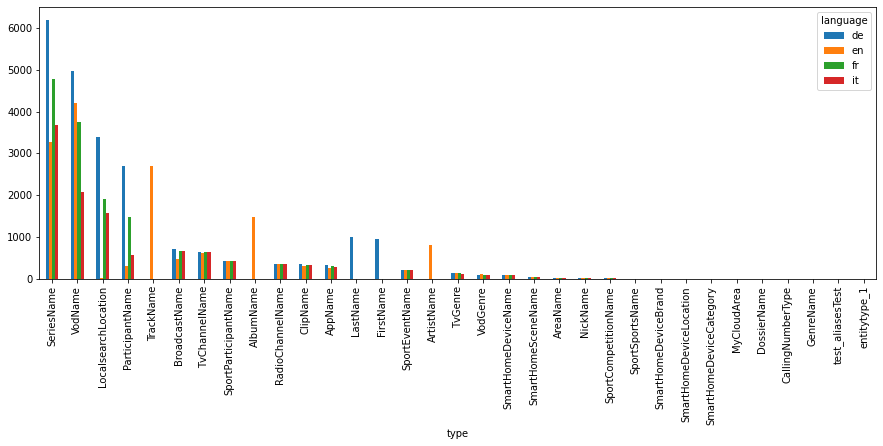

In [4]:
df = entities[['type', 'language']]
df = df.groupby(['type','language']).size().reset_index(name='count')
df2 = df.pivot(index='type', columns='language', values='count')
df2['sum'] = 0
df2 = df2.fillna(0)
for lang in ['de', 'en', 'fr', 'it',]:
    df2['sum'] += df2[lang]
# df.sort_values('count', ascending=False)
p = df2.sort_values('sum', ascending=False)[['de', 'en', 'fr', 'it']].plot(kind='bar', figsize=(15, 5))

## Entities_meta

In [3]:
# entities
entities_meta = pd.read_json("data/entities_meta.json").sort_index()
entities_meta.head()


value                 type language normalizedValue aliases
0     Widnau  LocalsearchLocation       de          widnau      []
1     Zurigo  LocalsearchLocation       it          zurigo      []
2  Solothurn  LocalsearchLocation       de       solothurn      []
3    Muttenz  LocalsearchLocation       de         muttenz      []
4       Lyss  LocalsearchLocation       de            lyss      []

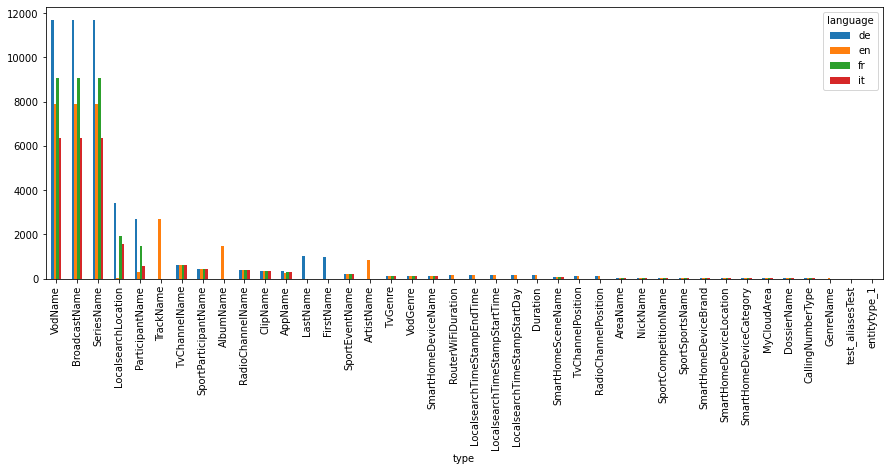

In [7]:
df = entities_meta[['type', 'language']]
df = df.groupby(['type','language']).size().reset_index(name='count')
df2 = df.pivot(index='type', columns='language', values='count')
df2['sum'] = 0
df2 = df2.fillna(0)
for lang in ['de', 'en', 'fr', 'it',]:
    df2['sum'] += df2[lang]
# df.sort_values('count', ascending=False)
p = df2.sort_values('sum', ascending=False)[['de', 'en', 'fr', 'it']].plot(kind='bar', figsize=(15, 5))


### Find the representative
One entity usually has various name, thus, to improve speed, we need to find the representative ones that could retrieve all.
Considering the speaking speed and noise of ASR, we decide to:
1. Combine abbreviation as a upper case word (s r f, S R F -> SRF)
2. Keep the uppercase one if two words spell same (Schweiz, schweiz -> Schweiz)

In [ ]:
# TODO: deal with case "a"
from generator.tools import filter_aliases
sample_aliases1 = [
    "TF 3",         # value
    "TF three",     # normalized
    "T F 3",        # alias
    "t f three",    # alias
    "t f 3"         # alias
    ]
filter_aliases(sample_aliases1,'en')

## Read custom template
For time related templates:
* Localsearch.TemperatureInfo.Init.Utterance
* Localsearch.RainInfo.Init.Utterance
* Localsearch.WeatherInfo.Init.Utterance

exist problem that they use "TimeStamp" to represent both clock time (3 o'clock) and day time ("tomorrow", "Monday", etc.)
But their use cases are different. So we updated general "TimeStamp" -> "TimeStampDay" and "TimeStampTime" for DE and EN

In [ ]:
# update template
df = pd.read_json("data/timestamp_de_noted.json")
templates_updated.update(df)

df = pd.read_json("data/timestamp_en_noted.json")
templates_updated.update(df)

## Generation

In [ ]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
gen.get_command(target_id='Localsearch.TemperatureInfo.Init.Utterance', target_lang='en', verbose=False)

In [ ]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
sample_size = 10000
f_source = open("data/commands_source_en_70k.txt", "a")
f_target = open("data/commands_target_en_70k.txt", "a")

for temp_id in ['Localsearch.TemperatureInfo.Init.Utterance' ,
                'Localsearch.RainInfo.Init.Utterance',
                'Localsearch.WeatherInfo.Init.Utterance',
                'Tv.TvSearch.Init.Utterance',
                'Tv.TvChannelChange.Init.Utterance',
                'Tv.RadioChannelChange.Init.Utterance',
                'SmartHome.SwitchOnDevice.Init.Utterance'
                ]:
    for _ in tqdm(range(sample_size)):
        command_en, label_en = gen.get_command(target_id=temp_id, target_lang='en', verbose=False)[0]
        f_source.write("{}\n".format(' '.join(command_en)))
        f_target.write("{}\n".format(' '.join(label_en)))
f_source.close()
f_target.close()

from generator.normalizer import Normalizer
f_source = open("data/nums_source_en_10k.txt", "a")
f_target = open("data/nums_target_en_10k.txt", "a")

for num in range(10000):
    num_str = str(num) 
    num_norm = Normalizer().normalize_text(num_str, 'en')
    f_source.write("{}\n".format(num_str))
    f_target.write("{}\n".format(num_norm))
f_source.close()
f_target.close()

In [ ]:
# update template
df = pd.read_json("data/timestamp_de_noted.json")
templates_updated.update(df)

df = pd.read_json("data/timestamp_en_noted.json")
templates_updated.update(df)

## Generation

In [ ]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
gen.get_command(target_id='Localsearch.TemperatureInfo.Init.Utterance', target_lang='en', verbose=False)

In [ ]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
sample_size = 10000
f_source = open("data/commands_source_en_70k.txt", "a")
f_target = open("data/commands_target_en_70k.txt", "a")

for temp_id in ['Localsearch.TemperatureInfo.Init.Utterance' ,
                'Localsearch.RainInfo.Init.Utterance',
                'Localsearch.WeatherInfo.Init.Utterance',
                'Tv.TvSearch.Init.Utterance',
                'Tv.TvChannelChange.Init.Utterance',
                'Tv.RadioChannelChange.Init.Utterance',
                'SmartHome.SwitchOnDevice.Init.Utterance'
                ]:
    for _ in tqdm(range(sample_size)):
        command_en, label_en = gen.get_command(target_id=temp_id, target_lang='en', verbose=False)[0]
        f_source.write("{}\n".format(' '.join(command_en)))
        f_target.write("{}\n".format(' '.join(label_en)))
f_source.close()
f_target.close()

In [5]:
from generator.normalizer import Normalizer
f_source = open("data/nums_source_en_10k.txt", "a")
f_target = open("data/nums_target_en_10k.txt", "a")

for num in range(10000):
    num_str = str(num) 
    num_norm = Normalizer().normalize_text(num_str, 'en')
    f_source.write("{}\n".format(num_str))
    f_target.write("{}\n".format(num_norm))
f_source.close()
f_target.close()

['TF 3']

## Read custom template
For time related templates:
* Localsearch.TemperatureInfo.Init.Utterance
* Localsearch.RainInfo.Init.Utterance
* Localsearch.WeatherInfo.Init.Utterance

exist problem that they use "TimeStamp" to represent both clock time (3 o'clock) and day time ("tomorrow", "Monday", etc.)
But their use cases are different. So we updated general "TimeStamp" -> "TimeStampDay" and "TimeStampTime" for DE and EN

In [ ]:
# update template
df = pd.read_json("data/timestamp_de_noted.json")
templates_updated.update(df)

df = pd.read_json("data/timestamp_en_noted.json")
templates_updated.update(df)

## Generation

In [ ]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
gen.get_command(target_id='Localsearch.TemperatureInfo.Init.Utterance', target_lang='en', verbose=False)

In [ ]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
sample_size = 10000
f_source = open("data/commands_source_en_70k.txt", "a")
f_target = open("data/commands_target_en_70k.txt", "a")

for temp_id in ['Localsearch.TemperatureInfo.Init.Utterance' ,
                'Localsearch.RainInfo.Init.Utterance',
                'Localsearch.WeatherInfo.Init.Utterance',
                'Tv.TvSearch.Init.Utterance',
                'Tv.TvChannelChange.Init.Utterance',
                'Tv.RadioChannelChange.Init.Utterance',
                'SmartHome.SwitchOnDevice.Init.Utterance'
                ]:
    for _ in tqdm(range(sample_size)):
        command_en, label_en = gen.get_command(target_id=temp_id, target_lang='en', verbose=False)[0]
        f_source.write("{}\n".format(' '.join(command_en)))
        f_target.write("{}\n".format(' '.join(label_en)))
f_source.close()
f_target.close()

from generator.normalizer import Normalizer
f_source = open("data/nums_source_en_10k.txt", "a")
f_target = open("data/nums_target_en_10k.txt", "a")

for num in range(10000):
    num_str = str(num) 
    num_norm = Normalizer().normalize_text(num_str, 'en')
    f_source.write("{}\n".format(num_str))
    f_target.write("{}\n".format(num_norm))
f_source.close()
f_target.close()

In [4]:
# update template
df = pd.read_json("data/timestamp_de_noted.json")
templates_updated.update(df)

df = pd.read_json("data/timestamp_en_noted.json")
templates_updated.update(df)

## Generation

In [6]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
gen.get_command(target_id='Localsearch.TemperatureInfo.Init.Utterance', target_lang='en', verbose=False)

[(['can',
   'you',
   'tell',
   'me',
   'how',
   'warm',
   'it',
   'will',
   'get',
   'on',
   '5.4'],
  ['can',
   'you',
   'tell',
   'me',
   'how',
   'warm',
   'it',
   'will',
   'get',
   'on',
   'fifth',
   'april'])]

In [7]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
sample_size = 10000
f_source = open("data/commands_source_en_70k.txt", "a")
f_target = open("data/commands_target_en_70k.txt", "a")

for temp_id in ['Localsearch.TemperatureInfo.Init.Utterance' ,
                'Localsearch.RainInfo.Init.Utterance',
                'Localsearch.WeatherInfo.Init.Utterance',
                'Tv.TvSearch.Init.Utterance',
                'Tv.TvChannelChange.Init.Utterance',
                'Tv.RadioChannelChange.Init.Utterance',
                'SmartHome.SwitchOnDevice.Init.Utterance'
                ]:
    for _ in tqdm(range(sample_size)):
        command_en, label_en = gen.get_command(target_id=temp_id, target_lang='en', verbose=False)[0]
        f_source.write("{}\n".format(' '.join(command_en)))
        f_target.write("{}\n".format(' '.join(label_en)))
f_source.close()
f_target.close()

100%|██████████| 10000/10000 [07:49<00:00, 21.32it/s]


In [4]:
from generator.normalizer import Normalizer
f_source = open("data/nums_source_en_10k.txt", "a")
f_target = open("data/nums_target_en_10k.txt", "a")

for num in range(10000):
    num_str = str(num) 
    num_norm = Normalizer().normalize_text(num_str, 'en')
    f_source.write("{}\n".format(num_str))
    f_target.write("{}\n".format(num_norm))
f_source.close()
f_target.close()